# Image Denoising

You are given a noisy binary image ($10 \times 10$ pixels) which you want to denoise.
<table><tr>
<td> <img src="gfx/camera_lego.jpg" width="250"/> </td>
<td> <img src="gfx/image_noisy_large.png" width="200"/> </td>
</tr></table>

Make use of the Ising model for that purpose where neighboring pixels are encouraged to take the same value:
$$p(x_1,\dots,x_{100}) \propto \exp \left\{\sum_{i=1}^{100} \psi_i(x_i) + \sum_{i\sim j} \psi_{ij} (x_i,x_j) \right\}$$
   	
Here, $i$ is the pixel index and $i\sim j$ are neighboring pixels on a 4-connected grid. The unary term $\psi_i(x_i) = [x_i = o_i]$ models the observation at pixel $i$, and the pairwise term is the Ising prior $\psi_{ij}(x_i,x_j) = \alpha \cdot [x_i = x_j]$, where $\alpha$ controls the strength of the interaction/smoothing. Because we have large number of variables in this exercise, we use logarithm factors to avoid potential numerical underflow issues.
   	
The code already contains the implementation of the Max-Product Belief Propagation Algorithm for general structured Markov Random Fields. 
Carefully study the code, understand all the data structures. The pseudocode for this algorithm is specified in the following. 

**Inputs:**
* `num_vars`, `num_states`, `factors`, `msg_fv`, `msg_vf`, `ne_var`

**Outputs:**
* `max_marginals`: `num_vars` x `num_states` array of estimated max-marginals
* `map_est`: array comprising the estimated MAP state of each variable

**Algorithm Pseudocode:**
* For `N=30` iterations do:
 * Update all unary factor-to-variable messages: $\lambda_{f\rightarrow x}(x) = f(x)$
 * Update all pairwise factor-to-variable messages: $\lambda_{f\rightarrow x}(x) = \max_y \left[f(x,y)+\lambda_{y\rightarrow f}(y)\right]$
 * Update all variable-to-factor messages: $\lambda_{x\rightarrow f}(x) = \sum_{g\in\{ ne(x)\setminus f\}}\lambda_{g\rightarrow x}(x)$
            
* Calculate Max-Marginals: $\gamma_x(x) = \sum_{g\in\{ ne(x)\}}\lambda_{g\rightarrow x}(x)$
* Calculate MAP Solution: $x^* = \underset{x}{\mathrm{argmax}} ~ \gamma_x(x)$

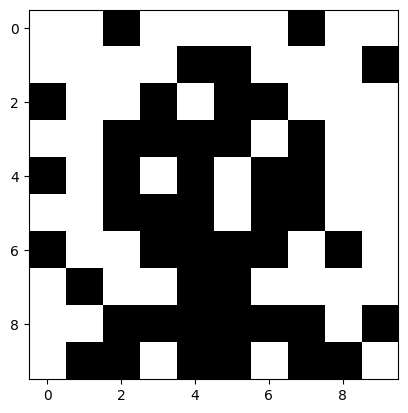

In [2]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import imageio

# load and plot input image
img = imageio.imread('gfx/image.png')/255
plt.imshow(img,interpolation='nearest')
plt.gray()
plt.show()


Set Model Parameters & Create Factors
 * `num_vars`: number of variables in MRF
 * `num_states`: number of states for each variable (binary -> num_states=2)
 * `factors`: list of dictionaries where each entry of the list comprises two variables: (`vars` = array of variables involved, `vals` = vector/matrix specifying the vector)
 
### Task 1
 
Add the unary and pairwise factors according to the formula given in the beginning. 

In [15]:
# model parameters
[h,w] = img.shape # get width & height of image
num_vars = w*h    # number of variables = width * height
num_states = 2    # binary segmentation -> two states

# initialize factors (list of dictionaries), each factor comprises:
#   vars: array of variables involved
#   vals: vector/matrix of factor values
factors = []

# add unary factors
for u in range(w):
  for v in range(h):
    
    # TODO
    factors.append({"vars": [u+v*w], "vals": np.array([1 - img[v, u], img[v, u]])})
    pass

# add pairwise factors
alpha = 0.4 # smoothness weight
E = alpha*np.array([[1,0],[0,1]]) # energy matrix for pairwise factor
for u in range(w):
  for v in range(h):
    
    # TODO
    if u < w-1:
      factors.append({"vars": [u+v*w, u+1+v*w], "vals": E})
    if v < h-1:
      factors.append({"vars": [u+v*w, u+(v+1)*w], "vals": E})
    pass


Initialize Messages
 * `msg_fv`: dictionary of all messages from factors to variables
 * `msg_vf`: dictionary of all messages from variables to factors
 * `ne_var`: list which comprises the neighboring factors of each variable

In [16]:
# initialize all messages
msg_fv = {} # f->v messages (dictionary)
msg_vf = {} # v->f messages (dictionary)
ne_var = [[] for i in range(num_vars)] # neighboring factors of variables (list of list)

# set messages to zero; determine factors neighboring each variable
for [f_idx,f] in enumerate(factors):
    for v_idx in f['vars']:
        msg_fv[(f_idx,v_idx)] = np.zeros(num_states) # factor->variable message
        msg_vf[(v_idx,f_idx)] = np.zeros(num_states) # variable->factor message
        ne_var[v_idx].append(f_idx) # factors neighboring variable v_idx

# status message
print("Messages initialized!")

Messages initialized!


Inference: Implementation of the Max-Product Belief Propagation Algorithm as outlined in the Pseudocode in the beginning.

In [17]:
# run inference
for it in range(30):
  
    # for all factor-to-variable messages do
    for [key,msg] in msg_fv.items():
        
        # shortcuts to variables
        f_idx = key[0] # factor (source)
        v_idx = key[1] # variable (target)
        f_vars = factors[f_idx]['vars'] # variables connected to factor
        f_vals = factors[f_idx]['vals'] # vector/matrix of factor values 

        # unary factor-to-variable message
        if np.size(f_vars)==1:
            msg_fv[(f_idx,v_idx)] = f_vals

        # pairwise factor-to-variable-message
        else:

            # if target variable is first variable of factor
            if v_idx==f_vars[0]:
                msg_in = np.tile(msg_vf[(f_vars[1],f_idx)],(num_states,1))
                msg_fv[(f_idx,v_idx)] = (f_vals+msg_in).max(1) # max over columns

            # if target variable is second variable of factor
            else:
                msg_in = np.tile(msg_vf[(f_vars[0],f_idx)],(num_states,1))
                msg_fv[(f_idx,v_idx)] = (f_vals+msg_in.transpose()).max(0) # max over rows
                
        # normalize
        msg_fv[(f_idx,v_idx)] = msg_fv[(f_idx,v_idx)] - np.mean(msg_fv[(f_idx,v_idx)])

    # for all variable-to-factor messages do
    for [key,msg] in msg_vf.items():
        
        # shortcuts to variables
        v_idx = key[0] # variable (source)
        f_idx = key[1] # factor (target)

        # add messages from all factors send to this variable (except target factor)
        # and send the result to the target factor
        msg_vf[(v_idx,f_idx)] = np.zeros(num_states)
        for f_idx2 in ne_var[v_idx]:
            if f_idx2 != f_idx:
                msg_vf[(v_idx,f_idx)] += msg_fv[(f_idx2,v_idx)]
                
        # normalize
        msg_vf[(v_idx,f_idx)] = msg_vf[(v_idx,f_idx)] - np.mean(msg_vf[(v_idx,f_idx)])
        
# calculate max-marginals (num_vars x num_states matrix)
max_marginals = np.zeros([num_vars,num_states])
for v_idx in range(num_vars):
    
    # add messages from all factors sent to this variable
    max_marginals[v_idx] = np.zeros(num_states)
    for f_idx in ne_var[v_idx]:
        max_marginals[v_idx] += msg_fv[(f_idx,v_idx)]
    #print max_marginals[v_idx]

# get MAP solution
map_est = np.argmax(max_marginals,axis=1)

Show Inference Results

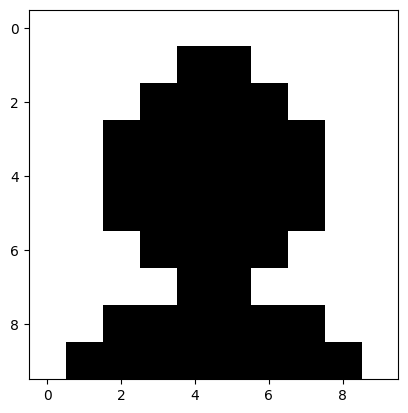

In [18]:
# plot MAP estimate
plt.imshow(map_est.reshape(h,w),interpolation='nearest');
plt.gray()
plt.show()

### Task 2: Smoothness Prior
   	
Using the code developed above, answer the following questions:
* Can you recover a noise-free image?
* With which parameter $\alpha$ is this possible?
* What happens when you increase or decrease $\alpha$?
* Show all distinct MAP estimates for $\alpha\in[0,1]$